In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.utils import shuffle
import plotly.graph_objects as go
import csv
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/warwick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/warwick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/warwick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [226]:
import re
from textblob import TextBlob
from pandas.tseries.offsets import BDay
from sklearn.linear_model import LinearRegression

In [105]:
tweets = pd.read_csv("data_elonmusk.csv", encoding='latin1')
tweets = tweets.assign(Time=pd.to_datetime(tweets.Time)).drop(['row ID','User'], axis='columns')
n_data = tweets.shape[0]
feature_list = tweets.columns
print("the number of tweets is:", n_data)
print("features are:", feature_list)
print("the number of features are:", len(feature_list))

the number of tweets is: 3218
features are: Index(['Tweet', 'Time', 'Retweet from'], dtype='object')
the number of features are: 3


In [106]:
times = tweets['Time'][:].tolist()
times = [times[i].strftime("%d%m%Y") for i in range(len(tweets))]
times = [times[i][4:8]+times[i][2:4]+times[i][0:2] for i in range(len(tweets))]
tweets.loc[:,("time_string")] = times
print(tweets['time_string'])

0       20170929
1       20170929
2       20170929
3       20170929
4       20170929
          ...   
3213    20121120
3214    20121120
3215    20121120
3216    20121119
3217    20121116
Name: time_string, Length: 3218, dtype: object


In [107]:
def remove_html(text):
    soup = BeautifulSoup(text, 'lxml')
    text_after = soup.get_text()
    return text_after

def remove_punctuation(text):
    text_after = "".join([c for c in text if c not in string.punctuation])
    return text_after

def remove_stopwords(text):
    text_after = [w for w in text if w not in stopwords.words('english')]
    return text_after

lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    text_after =[lemmatizer.lemmatize(i) for i in text]
    return text_after

def remove_url(input_str):
    str_p = re.compile(r'https?://\S+|www\.\S+')
    return str_p.sub(r'',input_str)

def remove_numbers(input_str):
    str_p = re.compile(r'\d')
    return str_p.sub(r'',input_str)

def preprocess_text(text):
    text = text.lower()
    text = remove_html(text)
    text = remove_numbers(text)
    text = remove_url(text)
    """
    text = lemmatize(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    """
    return text

def preprocess_data(data):
    text_list =[]
    for text in data:
        text_after = preprocess_text(text)
        text_list.append(text_after)
    return text_list

tweets_list = tweets['Tweet'].tolist()
tweets_text = preprocess_data(tweets_list)
tweets['tweets_clean'] = tweets_text

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:421: MarkupResemblesLocatorWarning: "https://t.co/iypzm9fdqk" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:421: MarkupResemblesLocatorWarning: "https://t.co/is6hthjjoj" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:421: MarkupResemblesLocatorWarning: "https://t.co/tj4frdw34z" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupRese

In [108]:
print(len(tweets_text))
print(tweets["tweets_clean"].head(5))

3218
0    @meltingice assuming max acceleration of  to  ...
1    rt @spacex: bfr is capable of transporting sat...
2                                       @bigajm yup :)
3                                               part  
4    fly to most places on earth in under  mins and...
Name: tweets_clean, dtype: object


0    1
1    1
2    1
3   -1
4    1
Name: sentiment, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/base.py:1145: FutureWarning: onOffset is a deprecated, use is_on_offset instead
  new_values = map_f(values, mapper)


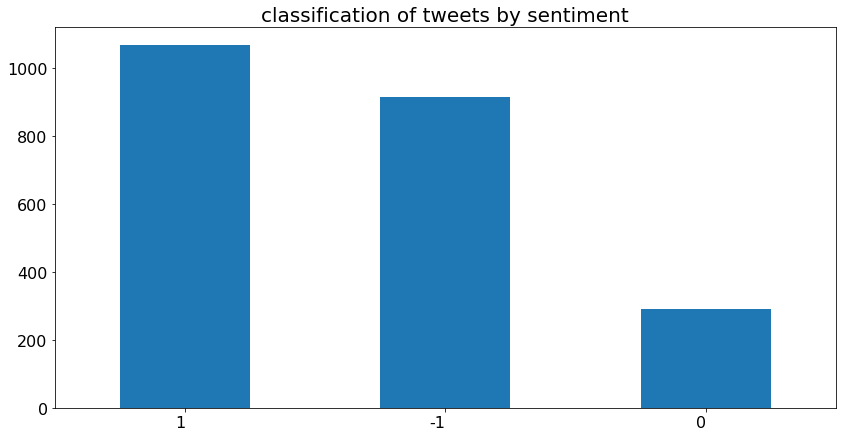

In [109]:
#implement TextBlob library to get the sentiment of a tweets
#return positive, negative and neutral 
def get_sentiment(tweet):
    tweet_polarity = TextBlob(tweet).sentiment.polarity
    if tweet_polarity>0:
        return 1
    elif tweet_polarity<0:
        return 0
    else:
        return -1
    
sentiment_list = [get_sentiment(i) for i in tweets_text]
sentiment_polarity_list = [TextBlob(i).sentiment.polarity for i in tweets_text]
tweets["sentiment"] = sentiment_list
tweets["polarity"] = sentiment_polarity_list

#we only consider tweets on business day
business_day = pd.to_datetime(tweets['Time']).map(BDay().onOffset)
tweets = tweets[business_day]


print(tweets["sentiment"].head(5))
tweets['sentiment'].value_counts().head(3).plot.bar(figsize=(14, 7), fontsize=16)
plt.gca().set_title('classification of tweets by sentiment', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=0, ha='right', fontsize=16)
pass

In [171]:
#get the sentiment score for each day
#the sentiment score is the sum of sentiment score of individual tweet in the same day
tweets_sentiment_polarity = tweets[['time_string','polarity']].copy()
tweets_sentiment_polarity = tweets_sentiment_polarity.groupby(tweets_sentiment_polarity.time_string).mean()
tweets_sentiment_polarity.sort_values(by=['time_string'], inplace=True)
print(tweets_sentiment_polarity.head(10))
print(type(tweets_sentiment_polarity))

             polarity
time_string          
20121116     0.000000
20121119     0.416667
20121120     0.046458
20121121     0.270833
20121122     0.116667
20121123     0.149306
20121127    -0.200000
20121128     0.288095
20121129     0.250000
20121204     0.034848
<class 'pandas.core.frame.DataFrame'>


In [118]:
tweets_sentiment = tweets[['time_string','sentiment']].copy()
tweets_sentiment = tweets_sentiment.groupby(tweets_sentiment.time_string).agg(lambda x: x.value_counts().index[0])
tweets_sentiment.sort_values(by=['time_string'], inplace=True)
tweets_sentiment

,sentiment
time_string,
20121116,-1
20121119,1
20121120,-1
20121121,1
20121122,-1
...,...
20170925,1
20170926,1
20170927,1


In [174]:
tesla_stock = pd.read_csv("TSLA.csv", encoding='latin1')
n_data = tesla_stock.shape[0]
feature_list = tesla_stock.columns
print("the number of stock data is:", n_data)
print("features are:", feature_list)
print("the number of features are:", len(feature_list))

times = tesla_stock['Date'][:].tolist()
times = [s.replace("-", "") for s in times]
tesla_stock.loc[:,("times")] = times

#we only consider stock between 2012/11/15 and 2017/09/29, in accord with Elon Musk's tweet
tesla = tesla_stock[(tesla_stock.times >= "20121115") & (tesla_stock.times <= "20170929")]
print(tesla['times'].head(1))
print(tesla['times'].tail(1))
print("the number of trading days between 2012/11/15 and 2017/09/29 is:",tesla.shape[0])

the number of stock data is: 2416
features are: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
the number of features are: 7
601    20121115
Name: times, dtype: object
1827    20170929
Name: times, dtype: object
the number of trading days between 2012/11/15 and 2017/09/29 is: 1227


In [200]:
#advanced model: LSTM regularized by Elon Musk tweet's sentiment polarity
#1. perform simple LSTM on the first 40% training set
#2. using this model to predict the next 30% validation set and 30% testing set
#3. for the validation set, we calculate the L1-norm of predict closing price and real closing price
#4. we perform a linear regression of polarity of tweets and L1-norm
#5. For the testing set, we add the result of LSTM prediction and linear regression on tweets polarity as the final prediction


#merge sentiment polarity and tesla stock price
print(tesla.columns)
tesla_time = tesla['times'].tolist()
polarity_list = []

tweet_time = [[index,row.values[0]] for index, row in tweets_sentiment_polarity.iterrows()]
print(tweet_time[:5])

for i in tesla_time:
    polarity_list.append(0.0)
    for [index, row] in tweet_time:
        if i == index:
            polarity_list = polarity_list[:-1]
            polarity_list.append(row)
    
tesla["polarity"] = polarity_list
print(tesla.columns)
print(tesla["polarity"].head())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'times',
       'polarity'],
      dtype='object')
[['20121116', 0.0], ['20121119', 0.4166666666666667], ['20121120', 0.04645833333333334], ['20121121', 0.2708333333333333], ['20121122', 0.11666666666666665]]
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'times',
       'polarity'],
      dtype='object')
601    0.000000
602    0.000000
603    0.416667
604    0.046458
605    0.270833
Name: polarity, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [218]:
close_price_dataframe = tesla.filter(['Close'])
close_price = close_price_dataframe.values
scaler = MinMaxScaler(feature_range=(0,1))
print("total number of stock data is:", len(close_price))

#create a scaled closing price
scaled_close_price = scaler.fit_transform(close_price)


#split data so that the first 40% data as training data and the next 30% as validation dataset
#and rest 30% as testing set
training_data_len = int(np.ceil(len(scaled_close_price) * 0.4 ))
validation_data_len = int(np.ceil(len(scaled_close_price) * 0.3 ))

train_data = scaled_close_price
x_train = []
y_train = []


#price of stock based on previous 1 month 
threshold = 30


#in LSTM, the value of y depends on previous 30 days
for i in range(threshold, len(train_data)):
    x_train.append(train_data[i-threshold:i, 0])
    y_train.append(train_data[i, 0])
    if i<= (threshold+1):
        print(x_train)
        print(y_train)
        
# Convert data to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))



total number of stock data is: 1227
[array([0.        , 0.00287989, 0.00592918, 0.00615506, 0.00465865,
       0.00369869, 0.00409396, 0.00375516, 0.00680445, 0.00810322,
       0.00847027, 0.01072901, 0.00869615, 0.00815969, 0.00869615,
       0.00945846, 0.01058784, 0.01259246, 0.01253599, 0.00787735,
       0.00844204, 0.01010786, 0.01064431, 0.01070078, 0.01019256,
       0.00897849, 0.00976904, 0.00782088, 0.00810322, 0.00677622])]
[0.00861143768705179]
[array([0.        , 0.00287989, 0.00592918, 0.00615506, 0.00465865,
       0.00369869, 0.00409396, 0.00375516, 0.00680445, 0.00810322,
       0.00847027, 0.01072901, 0.00869615, 0.00815969, 0.00869615,
       0.00945846, 0.01058784, 0.01259246, 0.01253599, 0.00787735,
       0.00844204, 0.01010786, 0.01064431, 0.01070078, 0.01019256,
       0.00897849, 0.00976904, 0.00782088, 0.00810322, 0.00677622]), array([0.00287989, 0.00592918, 0.00615506, 0.00465865, 0.00369869,
       0.00409396, 0.00375516, 0.00680445, 0.00810322, 0.00847027

In [297]:
#Build the LSTM model
model = Sequential()
#one hidden layer contains 50 neurons
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model with 1 epoch
model.fit(x_train, y_train, batch_size=1, epochs=1)

1197/1197 [==============================] - 9s 8ms/step - loss: 0.0037


In [320]:
test_data = scaled_close_price[training_data_len - threshold: training_data_len +validation_data_len, :]
#Create the data sets x_test and y_test
x_test = []
y_test = close_price[training_data_len:training_data_len+validation_data_len, :]
for i in range(threshold, len(test_data)):
    x_test.append(test_data[i-threshold:i, 0])
    
print("length of x_test:", len(x_test))
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)


predictions = scaler.inverse_transform(predictions)
# Plot the data
train = close_price_dataframe[:training_data_len]
print("length of training set:", train.shape[0])
valid = close_price_dataframe[training_data_len:training_data_len+validation_data_len]
print("length of validation set:", valid.shape[0])
valid['Predictions'] = predictions


"""

# Visualize the data
plt.figure(figsize=(20,10))
plt.title('LSTM of 2 layers',fontsize = 40)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close price', fontsize=20)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
"""

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("the root mean squared error of LSTM:", rmse)


length of x_test: 369
length of training set: 491
length of validation set: 369
the root mean squared error of LSTM: 11.202573992524046


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [326]:
#linear regression on the validation set
start_time = 491
end_time = 860

print(valid["Predictions"].head(1))
print(valid["Predictions"].tail(1))
valid_list = valid["Predictions"].tolist()

close_list = tesla["Close"].tolist()
close_list = close_list[start_time:end_time]
polarity_list = tesla["polarity"].tolist()
polarity_list = polarity_list[start_time:end_time]
polarity_list=np.asarray(polarity_list)

diff_list = [valid_list[i]-close_list[i] for i in range(0,len(valid_list))]
print(diff_list[:5])


linear_regression = LinearRegression()
linear_regression.fit(polarity_list.reshape(-1, 1), diff_list)
print("the coefficient is:", linear_regression.coef_)
print("the intersection is:", linear_regression.intercept_)

polarity_regularization_list = tesla["polarity"].tolist()[end_time:]
polarity_regularization_list= np.asarray(polarity_regularization_list)
regularization_list = linear_regression.predict(polarity_regularization_list.reshape(-1, 1))
print(regularization_list[:10])

1092    236.553879
Name: Predictions, dtype: float32
1460    257.326752
Name: Predictions, dtype: float32
[-1.54612721582032, -0.9937442343750149, -2.806671194335962, -2.21685757226561, 2.9988400078124755]
the coefficient is: [-2.1612013]
the intersection is: 4.550134381516269
[4.55013438 4.16111815 3.58531237 3.87475897 4.55013438 4.55013438
 4.472091   4.55013438 4.22595419 3.93312475]


In [191]:
#for the rest 30%, implement LSTM regularized by linear regression of polarity of tweets

True

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


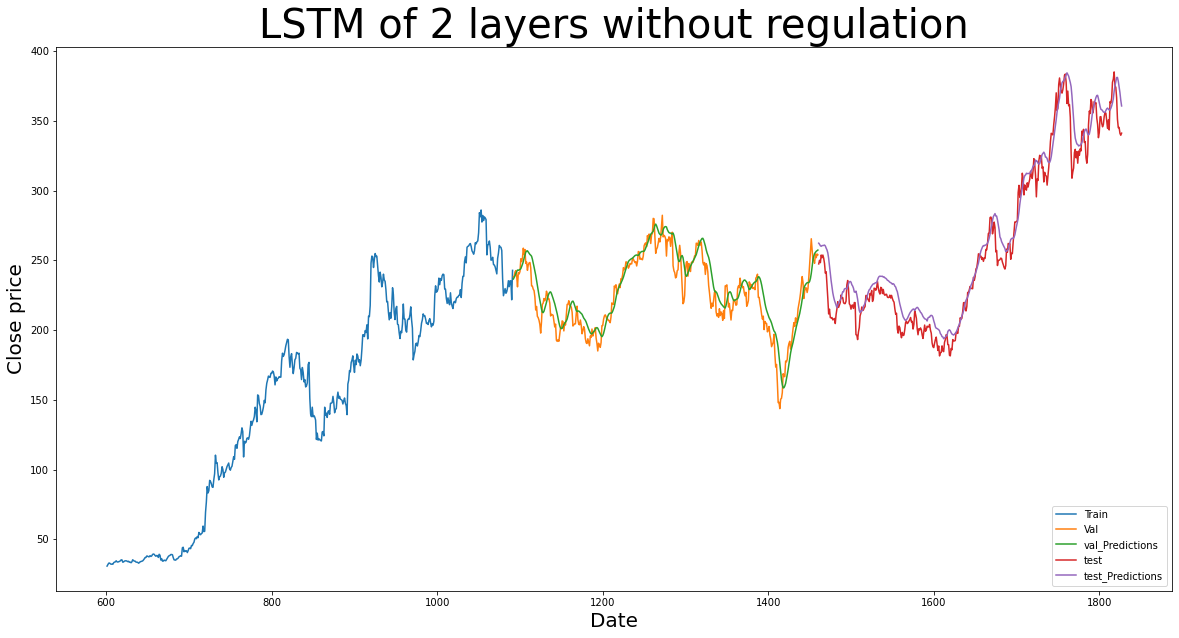

the root mean squared error of LSTM with regularization of tweets: 13.28572490477743


In [329]:
test_data = scaled_close_price[training_data_len + validation_data_len - threshold: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = close_price[training_data_len+validation_data_len:, :]
for i in range(threshold, len(test_data)):
    x_test.append(test_data[i-threshold:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


#add the linear regression of tweets to regularize prediction
predictions = [predictions[i]+regularization_list[i] for i in range(len(predictions))]


# Plot the data
test = close_price_dataframe[training_data_len+validation_data_len:]
test['test_Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(20,10))
plt.title('LSTM of 2 layers without regulation',fontsize = 40)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close price', fontsize=20)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(test[['Close','test_Predictions']])
plt.legend(['Train', 'Val', 'val_Predictions','test','test_Predictions'], loc='lower right')
plt.show()





# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("the root mean squared error of LSTM with regularization of tweets:", rmse)
